In [4]:
import numpy as np
import pandas as pd

from methodology.forecasting import compute_rmse_df, compute_mape_df

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [5]:
# Load the data and calculate the inflation rate
cpi_monthly_data = pd.read_csv("methodology/data/cpi_monthly_data.csv", index_col=0)
cpi = cpi_monthly_data[["00"]]
inflation_rate = cpi.pct_change(12).dropna(how="all") * 100
inflation_rate.columns = ["Inflation Rate"]
inflation_rate.index = pd.to_datetime(inflation_rate.index)

## AR Processes

In [3]:
from methodology.ar_forecasts import rolling_ar_forecast, rolling_bic_ar_forecast

#### Fixed Order Models

In [4]:
ar_forecasts = []
for p in [1, 2, 12, 13, 25]:
    ar_forecasts.append(rolling_ar_forecast(inflation_rate, p, n=240, h=12, start="2009-12-01", end="2024-11-01"))
ar_forecasts = pd.concat(ar_forecasts, axis=1)
compute_rmse_df(ar_forecasts)

,AR(1),AR(2),AR(12),AR(13),AR(25)
1,0.435603,0.426336,0.401967,0.385799,0.374275
2,0.682327,0.664866,0.587701,0.592114,0.569124
3,0.908605,0.872313,0.749007,0.778772,0.735917
4,1.157931,1.110514,0.942539,0.977393,0.936065
5,1.413634,1.357173,1.139758,1.182805,1.134967
6,1.667510,1.594833,1.329426,1.379411,1.324341
7,1.930331,1.841682,1.541590,1.607876,1.569201
8,2.195653,2.088775,1.750534,1.825949,1.792777
9,2.453081,2.328397,1.948559,2.024636,2.020153
10,2.687290,2.535645,2.102327,2.195529,2.223969


#### BIC

In [5]:
bic_ar, bic_p = rolling_bic_ar_forecast(inflation_rate, 240, 12, "2009-12-01", "2024-11-01")
compute_rmse_df(bic_ar)

,AR(p)
1,0.406896
2,0.604941
3,0.791752
4,1.014700
5,1.223595
6,1.431241
7,1.673485
8,1.909771
9,2.136116
10,2.328073


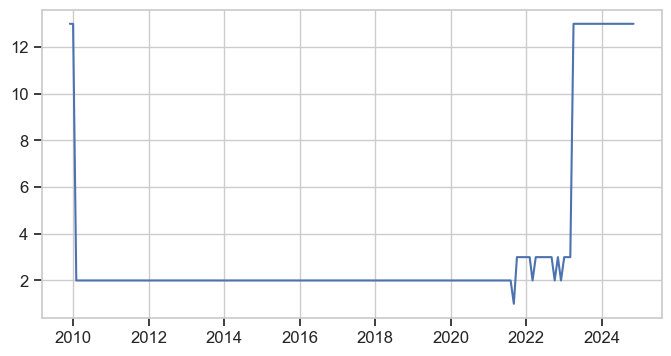

In [6]:
fig,ax = plt.subplots(figsize=(8,4))
plt.plot(inflation_rate.loc["2009-12-01":"2024-11-01"].index, bic_p)

#### Model Averaging

In [7]:
avar = pd.DataFrame(index=ar_forecasts.index, columns=pd.MultiIndex.from_product([["AvAR({1,13,25})", "AvAR({2,13,25})"], range(1, 13)]))
avar.loc[:, "AvAR({1,13,25})"] = (ar_forecasts["AR(1)"].to_numpy() + ar_forecasts["AR(13)"].to_numpy() + ar_forecasts["AR(25)"].to_numpy()) / 3
avar.loc[:, "AvAR({2,13,25})"] = (ar_forecasts["AR(2)"].to_numpy() + ar_forecasts["AR(13)"].to_numpy() + ar_forecasts["AR(25)"].to_numpy()) / 3
compute_rmse_df(avar)

,"AvAR({1,13,25})","AvAR({2,13,25})"
1,0.373667,0.373416
2,0.570861,0.570423
3,0.743804,0.740266
4,0.938046,0.933990
5,1.136915,1.132838
6,1.328000,1.321084
7,1.548744,1.539741
8,1.762178,1.750170
9,1.966474,1.951764
10,2.145959,2.127022


## Random Walks

In [8]:
from methodology.rw_forecasts import rolling_rw_forecast

In [9]:
rw_forecasts = pd.concat([rolling_rw_forecast(inflation_rate, q=q, h=12, start="2009-12-01", end="2024-11-01") for q in [1, 4]], axis=1)
compute_rmse_df(rw_forecasts)

,RW(1),RW(4)
1,0.429879,0.726718
2,0.666050,0.961382
3,0.878810,1.194053
4,1.107496,1.425379
5,1.338400,1.651591
6,1.562933,1.873838
7,1.792595,2.087081
8,2.017359,2.290935
9,2.229941,2.486206
10,2.419694,2.669990


## Amazon Chronos

In [1]:
from chronos import BaseChronosPipeline
import torch

/Users/henry/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dates = inflation_rate.loc["2009-12-01":"2024-11-01"].index
models = ["Chronos (Tiny)", "Chronos (Base)", "Chronos (Large)"]
chronos_df = pd.DataFrame(index=dates, columns=pd.MultiIndex.from_product([models, range(1, 13)]))

In [8]:
# Chronos (Tiny)
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny", 
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

for date in dates:
    # Get the inflation rate data up to the current time step
    past_data = inflation_rate.loc[:date].to_numpy().flatten()
    # Make a forecast for the next 12 months
    quantiles, mean = pipeline.predict_quantiles(
        context=torch.tensor(past_data),
        prediction_length=12,
        quantile_levels=[0.1, 0.5, 0.9],
    )
    chronos_df.loc[date, "Chronos (Tiny)"] = mean.flatten().numpy()

In [ ]:
# Chronos (Base)
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base", 
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

for date in dates:
    # Get the inflation rate data up to the current time step
    past_data = inflation_rate.loc[:date].to_numpy().flatten()
    # Make a forecast for the next 12 months
    quantiles, mean = pipeline.predict_quantiles(
        context=torch.tensor(past_data),
        prediction_length=12,
        quantile_levels=[0.1, 0.5, 0.9],
    )
    chronos_df.loc[date, "Chronos (Base)"] = mean.flatten().numpy()

In [ ]:
# Chronos (Large)
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large", 
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

for date in dates:
    # Get the inflation rate data up to the current time step
    past_data = inflation_rate.loc[:date].to_numpy().flatten()
    # Make a forecast for the next 12 months
    quantiles, mean = pipeline.predict_quantiles(
        context=torch.tensor(past_data),
        prediction_length=12,
        quantile_levels=[0.1, 0.5, 0.9],
    )
    chronos_df.loc[date, "Chronos (Large)"] = mean.flatten().numpy()

In [9]:
compute_rmse_df(chronos_df)

,Chronos (Tiny),Chronos (Base),Chronos (Large)
1,0.410524,NaN,NaN
2,0.624709,NaN,NaN
3,0.824108,NaN,NaN
4,1.049336,NaN,NaN
5,1.282579,NaN,NaN
6,1.510383,NaN,NaN
7,1.750503,NaN,NaN
8,1.987685,NaN,NaN
9,2.208886,NaN,NaN
10,2.401529,NaN,NaN


## Bank of England

In [10]:
from methodology.bank_of_england import rmse_vs_bank, mape_vs_bank

FileNotFoundError: [Errno 2] No such file or directory: 'data/cpi_monthly_data.csv'